<a href="https://colab.research.google.com/github/Myavuzars/MachineLearning/blob/main/Churn5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#SKLEARN
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/Machine Learning /Customer-Churn.csv")

df.head(4)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No


In [6]:
df.drop(['customerID'], axis=1, inplace=True)

In [7]:
#Splitting data into Numerical and Categorical
catdf =df.iloc[:,:-3]
numdf= df.iloc[:,-3:-1]
y= df.iloc[:,-1]
numdf.head()

,MonthlyCharges,TotalCharges
0,29.85,29.85
1,56.95,1889.5
2,53.85,108.15
3,42.30,1840.75
4,70.70,151.65


In [8]:
#Converting data into Categorical
def convert_cat(df):
  for col in df.columns:
      df[col] = df[col].astype('category')

convert_cat(catdf)

In [9]:
#Removing missing variables
numdf['TotalCharges']=numdf['TotalCharges'].str.replace(' ','0').astype('float64')

In [10]:
#Encoding Categoricl Variables
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()

for col in catdf:
  catdf[col] = encoder.fit_transform(catdf[col])

In [11]:
#Encoding Target Variable
y= encoder.fit_transform(y)

In [12]:
#Scaling Numerical Variables
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
numdf =scaler.fit_transform(numdf)
numdf =pd.DataFrame(numdf)

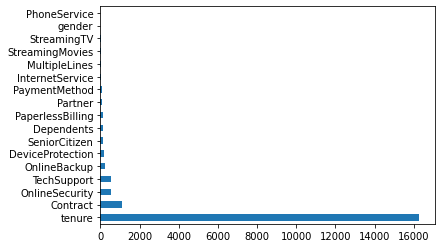

In [13]:
#Chi Square Independency Testing  
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
k=len(catdf.columns)
test = SelectKBest(score_func=chi2, k=k) 
fit = test.fit(catdf, y)
fit.scores_

imp = pd.Series(fit.scores_, index= catdf.columns)
imp.nlargest(k).plot(kind="barh")
plt.show()

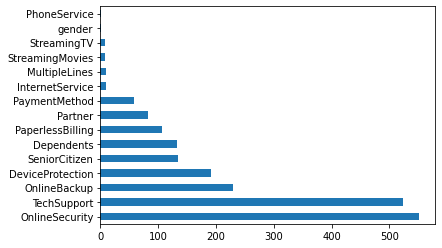

In [14]:
#Chi Square Independency Testing after removing tenure and Contract to see the better picture
cat_df =catdf.drop(['tenure', 'Contract'], axis=1)

k=len(cat_df.columns)
test = SelectKBest(score_func=chi2, k=k) 
fit = test.fit(cat_df, y)
fit.scores_

imp = pd.Series(fit.scores_, index= cat_df.columns)
imp.nlargest(k).plot(kind="barh")
plt.show()

In [15]:
# It is better drop the columns that scores lower than Payment Method 
new_catdf = catdf.drop(['PhoneService', 'gender', 'StreamingTV', 'MultipleLines'], axis=1)
new_catdf.head()

,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,0,1,0,1,0,0,2,0,0,0,0,1,2
1,0,0,0,34,0,2,0,2,0,0,1,0,3
2,0,0,0,2,0,2,2,0,0,0,0,1,3
3,0,0,0,45,0,2,0,2,2,0,1,0,0
4,0,0,0,2,1,0,0,0,0,0,0,1,2


In [16]:
new_catdf.nunique()

SeniorCitizen        2
Partner              2
Dependents           2
tenure              73
InternetService      3
OnlineSecurity       3
OnlineBackup         3
DeviceProtection     3
TechSupport          3
StreamingMovies      3
Contract             3
PaperlessBilling     2
PaymentMethod        4
dtype: int64

In [17]:
#One hot encoding for categorical variables
ndf = pd.get_dummies(new_catdf, columns=['SeniorCitizen','InternetService', 'Partner','Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingMovies','Contract', 'PaperlessBilling','PaymentMethod'], drop_first = True)

ndf.head()

,tenure,SeniorCitizen_1,InternetService_1,InternetService_2,Partner_1,Dependents_1,OnlineSecurity_1,OnlineSecurity_2,OnlineBackup_1,OnlineBackup_2,DeviceProtection_1,DeviceProtection_2,TechSupport_1,TechSupport_2,StreamingMovies_1,StreamingMovies_2,Contract_1,Contract_2,PaperlessBilling_1,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3
0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
1,34,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,45,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0
4,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [18]:
#Generating X Data set after Feature Reduction
X = pd.concat([ndf,numdf], axis=1 )
X.head()

,tenure,SeniorCitizen_1,InternetService_1,InternetService_2,Partner_1,Dependents_1,OnlineSecurity_1,OnlineSecurity_2,OnlineBackup_1,OnlineBackup_2,DeviceProtection_1,DeviceProtection_2,TechSupport_1,TechSupport_2,StreamingMovies_1,StreamingMovies_2,Contract_1,Contract_2,PaperlessBilling_1,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,0,1
0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,-1.160323,-0.992611
1,34,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,-0.259629,-0.172165
2,2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,-0.362660,-0.958066
3,45,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,-0.746535,-0.193672
4,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.197365,-0.938874


In [19]:
#Data Set Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [20]:
#copy of data partitinos for SMOTE texchniques

In [21]:
#SMOTE library
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import TomekLinks

In [22]:
#SMOTE Techniques

#1. SMOTE with Tomek Links 
resample=TomekLinks(sampling_strategy='majority')

#2. KMeansSMOTE
over1 = KMeansSMOTE()
under = RandomUnderSampler()

#3. SVMSMOTE
over2 = SVMSMOTE()
under = RandomUnderSampler()


In [23]:
# Define Pipelines 

# define steps
steps1 = [('r', resample)] 
steps2 = [('o', over1), ('u', under)]
steps3 = [('o', over2), ('u', under)]

#Pipelines
pipeline1 = Pipeline(steps=steps1)
pipeline2 = Pipeline(steps=steps2)
pipeline3 = Pipeline(steps=steps3)


In [ ]:
#New Samplings

In [24]:
# SMOTE_Tomek Sampling
X1_train, y1_train = pipeline1.fit_resample(X_train, y_train)
X2_train, y2_train = pipeline1.fit_resample(X_train, y_train)
X3_train, y3_train = pipeline1.fit_resample(X_train, y_train)
X4_train, y4_train = pipeline1.fit_resample(X_train, y_train)

In [25]:
#  KMEANS_SMOTE Sampling
X5_train, y5_train = pipeline2.fit_resample(X_train, y_train)
X6_train, y6_train = pipeline2.fit_resample(X_train, y_train)
X7_train, y7_train = pipeline2.fit_resample(X_train, y_train)
X8_train, y8_train = pipeline2.fit_resample(X_train, y_train)

In [26]:
#  SVMMOTE Sampling
X9_train,  y9_train = pipeline3.fit_resample(X_train, y_train)
X10_train, y10_train = pipeline3.fit_resample(X_train, y_train)
X11_train, y11_train = pipeline3.fit_resample(X_train, y_train)
X12_train, y12_train = pipeline3.fit_resample(X_train, y_train)
X13_train, y13_train = pipeline3.fit_resample(X_train, y_train)


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Models Import
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.svm import SVC

In [ ]:
# Estimators
def estimators():
  mod_names = list()

  #1. Weighted Logistic Regression with SMOTE TOMEKS LINKS
  model_LGT =  LogisticRegression(solver='newton-cg', class_weight={0: 0.27, 1: 0.73})
  model_LGT.fit(X1_train, y1_train)
  mod_names.append(("LGT",model_LGT))

  #2. Weighted Logistic Regression with Kmeans SMOTE
  model_LGK = LogisticRegression(solver='newton-cg', class_weight={0: 0.27, 1: 0.73})
  model_LGK.fit(X5_train, y5_train)
  mod_names.append(('LGK', model_LGK))

  #3. Weighted Logistic Regression with SVMSMOTE
  model_LGS = LogisticRegression(solver='newton-cg', class_weight={0: 0.27, 1: 0.73})
  model_LGS.fit(X9_train, y9_train)
  mod_names.append(('LGS' , model_LGS))

  # 4.Weighted Logistic Regression without SMOTE
  model_LOG = LogisticRegression(solver='newton-cg', class_weight={0: 0.27, 1: 0.73})
  model_LOG.fit(X_train, y_train)
  mod_names.append(("LOG", model_LOG))

  # 5.GRADIENT BOOSTING REGRESSION with SMOTE TOMEK LINKS
  model_GBT = GradientBoostingClassifier()
  model_GBT.fit(X2_train, y2_train)
  mod_names.append(('GBT', model_GBT))

  # 6.GRADIENT BOOSTING REGRESSION with Kmeans SMOTE
  model_GBK = GradientBoostingClassifier()
  model_GBK.fit(X6_train, y6_train)
  mod_names.append(('GBK', model_GBK))

  # 7.GRADIENT BOOSTING REGRESSION with SVMSMOTE
  model_GBS = GradientBoostingClassifier()
  model_GBS.fit(X10_train, y10_train)
  mod_names.append(('GBS', model_GBS))

  # 8.GRADIENT BOOSTING REGRESSION without SMOTE
  model_GB = GradientBoostingClassifier()
  model_GB.fit(X_train, y_train)
  mod_names.append(('GB', model_GB))

  # 9.EXTREME GRADIENT BOOSTING with SMOTE TOMEK LINKS
  model_XGBT = XGBClassifier()
  model_XGBT.fit(X3_train, y3_train)
  mod_names.append(('XGBT', model_XGBT))

  # 10.EXTREME GRADIENT BOOSTING with with Kmeans SMOTE
  model_XGBK = XGBClassifier()
  model_XGBK.fit(X7_train, y7_train)
  mod_names.append(('XGBK', model_XGBK))

  # 11.EXTREME GRADIENT BOOSTING with SVMSMOTE
  model_XGBS = XGBClassifier()
  model_XGBS.fit(X11_train, y11_train)
  mod_names.append(('XGBS', model_XGBS))

  # 12.EXTREME GRADIENT BOOSTING without SMOTE
  model_XGB = XGBClassifier()
  model_XGB.fit(X_train, y_train)
  mod_names.append(('XGB', model_XGB))


  return mod_names

In [ ]:
def best_threshold(model):
  mod=model[1]
  
  # predict probabilities
  YHAT =mod.predict_proba(X_test)  

  # Probabilities for the positive outcome only
  yhat = YHAT[:, 1]

  # calculate roc curves
  Precision, Recall, Thresholds = precision_recall_curve(y_test, yhat)

  # F1-Score
  F1score = (2 * Precision * Recall) / (Precision + Recall)

  # locate the index of the largest f-measure
  ix = np.argmax(F1score)

  Best_threshold = round(Thresholds[ix],3)
  Best_fscore = round(F1score[ix],3)
  Best_recall = round(Recall[ix],3)
  Best_precision = round(Precision[ix],3)

  return Best_threshold , Best_fscore, Best_recall, Best_precision


In [ ]:
def results():
  scores={}  
  for model in estimators():
    scores[model[0]] = best_threshold(model)
  return scores

In [ ]:
Result=results()
Result

{'GB': (0.34, 0.628, 0.717, 0.558),
 'GBK': (0.317, 0.624, 0.767, 0.526),
 'GBS': (0.648, 0.625, 0.649, 0.604),
 'GBT': (0.329, 0.632, 0.782, 0.531),
 'LGK': (0.771, 0.635, 0.692, 0.586),
 'LGS': (0.833, 0.625, 0.67, 0.586),
 'LGT': (0.755, 0.632, 0.612, 0.653),
 'LOG': (0.696, 0.63, 0.621, 0.64),
 'XGB': (0.328, 0.635, 0.749, 0.55),
 'XGBK': (0.369, 0.627, 0.724, 0.552),
 'XGBS': (0.586, 0.625, 0.698, 0.566),
 'XGBT': (0.395, 0.635, 0.73, 0.562)}

In [ ]:
# 5.SVM MODELS (Choosing best C value and sampling)
def best_SVM():
  mod_names = list()

  c =  np.linspace(0.2,5.0, 6)

  for i in c:

    #1. Weighted SVM with SMOTE TOMEKS LINKS
    model_SVMT =  SVC(kernel='linear',class_weight={0: 0.32, 1: 0.68}, C=i, random_state=0, probability=True)
    model_SVMT.fit(X4_train, y4_train)
    mod_names.append(("SVMT",model_SVMT,i))

    #2. Weighted SVM with Kmeans SMOTE
    model_SVMK = SVC(kernel='linear',class_weight={0: 0.32, 1: 0.68}, C=i, random_state=0, probability=True)
    model_SVMK.fit(X8_train, y8_train)
    mod_names.append(('SVMK', model_SVMK,i))

  
    #3.Weighted SVM without SMOTE
    model_SVM = SVC(kernel='linear',class_weight={0: 0.32, 1: 0.68}, C=i, random_state=0, probability=True)
    model_SVM.fit(X_train, y_train)
    mod_names.append(("SVM", model_SVM,i))

  
  return mod_names

In [ ]:
bests= best_SVM()


In [ ]:
for i in bests:
  print(i[1])

SVC(C=0.2, class_weight={0: 0.32, 1: 0.68}, kernel='linear', probability=True,
    random_state=0)
SVC(C=0.2, class_weight={0: 0.32, 1: 0.68}, kernel='linear', probability=True,
    random_state=0)
SVC(C=0.2, class_weight={0: 0.32, 1: 0.68}, kernel='linear', probability=True,
    random_state=0)
SVC(C=1.16, class_weight={0: 0.32, 1: 0.68}, kernel='linear', probability=True,
    random_state=0)
SVC(C=1.16, class_weight={0: 0.32, 1: 0.68}, kernel='linear', probability=True,
    random_state=0)
SVC(C=1.16, class_weight={0: 0.32, 1: 0.68}, kernel='linear', probability=True,
    random_state=0)
SVC(C=2.12, class_weight={0: 0.32, 1: 0.68}, kernel='linear', probability=True,
    random_state=0)
SVC(C=2.12, class_weight={0: 0.32, 1: 0.68}, kernel='linear', probability=True,
    random_state=0)
SVC(C=2.12, class_weight={0: 0.32, 1: 0.68}, kernel='linear', probability=True,
    random_state=0)
SVC(C=3.08, class_weight={0: 0.32, 1: 0.68}, kernel='linear', probability=True,
    random_state=0)
SVC

In [ ]:
def best_C(model):

  model_C= model[1]
  # predict probabilities
  YHAT = model_C.predict_proba(X_test)

  # keep probabilities for the positive outcome only
  yhat = YHAT[:, 1]

  # calculate roc curves
  Precision, Recall, Thresholds = precision_recall_curve(y_test, yhat)

  # F1-Score
  F1score = (2 * Precision * Recall) / (Precision + Recall)

  # index of the highest F1
  ix = np.argmax(F1score)

  Best_threshold = round(Thresholds[ix],3)
  Best_fscore = round(F1score[ix],3)
  Best_recall = round(Recall[ix],3)
  Best_precision = round(Precision[ix],3)

  return Best_threshold , Best_fscore, Best_recall, Best_precision



In [ ]:
def results_SVM():
  scores={}  
  for model in bests:
    scores[model[0]] = best_C(model)
  return scores

In [ ]:
ResultSVM =results_SVM()
ResultSVM

{'SVM': (0.463, 0.642, 0.655, 0.63),
 'SVMK': (0.661, 0.638, 0.687, 0.594),
 'SVMT': (0.521, 0.643, 0.662, 0.626)}

In [ ]:
Result

{'GB': (0.34, 0.628, 0.717, 0.558),
 'GBK': (0.317, 0.624, 0.767, 0.526),
 'GBS': (0.648, 0.625, 0.649, 0.604),
 'GBT': (0.329, 0.632, 0.782, 0.531),
 'LGK': (0.771, 0.635, 0.692, 0.586),
 'LGS': (0.833, 0.625, 0.67, 0.586),
 'LGT': (0.755, 0.632, 0.612, 0.653),
 'LOG': (0.696, 0.63, 0.621, 0.64),
 'XGB': (0.328, 0.635, 0.749, 0.55),
 'XGBK': (0.369, 0.627, 0.724, 0.552),
 'XGBS': (0.586, 0.625, 0.698, 0.566),
 'XGBT': (0.395, 0.635, 0.73, 0.562)}

In [ ]:
comparison5_df= pd.DataFrame({
    "Models" :             ["GB",                    "GB_KmeansSmOTE",        "GB SVMSMOTE",       "GB SMOTE TOMEKS",    "LOG KMeansMOTE",         "LOG SVMSMOTE",       "LOG SMOTE TOMEKS",              "XGB",          "XGB KMeansSMOTE",           "XGB SVMSMOTE",              "XGB SMOTE TOMEKS" ,     "SVM",                         "SVM SMOTE TOMEKS",         "SVM KMeansSMOTE"      ],
    "Threshold" :          [Result.get('GB')[0],   Result.get( 'GBK')[0],  Result.get('GBS')[0],  Result.get('GBT')[0],  Result.get('LGK')[0],  Result.get( 'LGS')[0],   Result.get('LGT')[0],  Result.get('XGB')[0],    Result.get('XGBK')[0],       Result.get('XGBS')[0],       Result.get('XGBT')[0],     ResultSVM.get('SVM')[0],    ResultSVM.get('SVMT')[0],    ResultSVM.get('SVMK')[0]],
    "F1 Scores"   : [Result.get('GB')[1],   Result.get( 'GBK')[1],  Result.get('GBS')[1],  Result.get('GBT')[1],  Result.get('LGK')[1],  Result.get( 'LGS')[1],   Result.get('LGT')[1],  Result.get('XGB')[1],    Result.get('XGBK')[1],       Result.get('XGBS')[1],       Result.get('XGBT')[1],     ResultSVM.get('SVM')[1],    ResultSVM.get('SVMT')[1],    ResultSVM.get('SVMK')[1]],
    "Recall Scores"     :  [Result.get('GB')[2],   Result.get( 'GBK')[2],  Result.get('GBS')[2],  Result.get('GBT')[2],  Result.get('LGK')[2],  Result.get( 'LGS')[2],   Result.get('LGT')[2],  Result.get('XGB')[2],    Result.get('XGBK')[2],       Result.get('XGBS')[2],       Result.get('XGBT')[2],     ResultSVM.get('SVM')[2],    ResultSVM.get('SVMT')[2],    ResultSVM.get('SVMK')[2]],
    "Precision Scores" :          [Result.get('GB')[3],   Result.get( 'GBK')[3],  Result.get('GBS')[3],  Result.get('GBT')[3],  Result.get('LGK')[3],  Result.get( 'LGS')[3],   Result.get('LGT')[3],  Result.get('XGB')[3],    Result.get('XGBK')[3],       Result.get('XGBS')[3],       Result.get('XGBT')[3],     ResultSVM.get('SVM')[3],    ResultSVM.get('SVMT')[3],    ResultSVM.get('SVMK')[3]]
    })

comparison5_df= comparison5_df.sort_values(["F1 Scores"], ascending=False)

comparison5_df

,Models,Threshold,F1 Scores,Recall Scores,Precision Scores
12,SVM SMOTE TOMEKS,0.521,0.643,0.662,0.626
11,SVM,0.463,0.642,0.655,0.630
13,SVM KMeansSMOTE,0.661,0.638,0.687,0.594
4,LOG KMeansMOTE,0.771,0.635,0.692,0.586
7,XGB,0.328,0.635,0.749,0.550
10,XGB SMOTE TOMEKS,0.395,0.635,0.730,0.562
3,GB SMOTE TOMEKS,0.329,0.632,0.782,0.531
6,LOG SMOTE TOMEKS,0.755,0.632,0.612,0.653
0,GB,0.340,0.628,0.717,0.558
8,XGB KMeansSMOTE,0.369,0.627,0.724,0.552


Best Threshold=0.520692, F1_Score=0.643
Best Threshold=0.002614, Recall_Score=1.000, Precision_Score=0.278


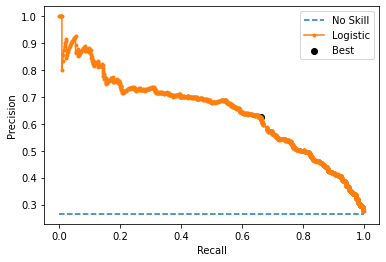

In [ ]:
# 5.BEST F1 Score with SVMSMOTE TOMEKS

model_SVMT =  SVC(kernel='linear',class_weight={0: 0.32, 1: 0.68}, C=4.04, random_state=0, probability=True)
model_SVMT.fit(X4_train, y4_train)
# predict probabilities
SVMR_yhat = model_SVMT.predict_proba(X_test)

# keep probabilities for the positive outcome only
yhatSVMR = SVMR_yhat[:, 1]

# calculate roc curves
SVM_precision, SVM_recall, thresholds = precision_recall_curve(y_test, yhatSVMR)

# convert to f-measure
SVM_fscore = (2 * SVM_precision * SVM_recall) / (SVM_precision + SVM_recall)

# locate the index of the largest f-measure
ix = np.argmax(SVM_fscore)
iy = np.argmax(SVM_recall)

SVM_Best_fscore = SVM_fscore[ix]
SVM_Best_precision =SVM_recall[ix]
SVM_Best_recall = SVM_precision[ix]

print('Best Threshold=%f, F1_Score=%.3f' % (thresholds[ix], SVM_fscore[ix]))
print('Best Threshold=%f, Recall_Score=%.3f, Precision_Score=%.3f' % (thresholds[iy], SVM_recall[iy], SVM_precision[iy] ))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(SVM_recall, SVM_precision, marker='.', label='Logistic')
plt.scatter(SVM_recall[ix], SVM_precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()